In [6]:
import torch
from modules.model import ConvNet
from modules.auxiliary import hyper_params
from modules.train_test import *
from modules.custom_dataset import MyData
from torchsummary import summary
import torchvision.transforms.functional as TF

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modules.train_test import train,test
from modules.auxiliary import *

import cv2
from warnings import filterwarnings

In [7]:
sns.set_style('darkgrid')

In [8]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

## Data Loading

In [5]:
train_loader_64_base, test_loader_64_base = torch.load('./DataLoaders/train_loader_64_base.pth'),\
                                           torch.load('./DataLoaders/test_loader_64_base.pth')

train_loader_32, test_loader_32 = torch.load('./DataLoaders/train_loader_32.pth'),\
                                 torch.load('./DataLoaders/test_loader_32.pth')

train_loader_64_resized, test_loader_64_resized = torch.load('./DataLoaders/train_loader_64_resized.pth'),\
                                                  torch.load('./DataLoaders/test_loader_64_resized.pth')

## Weights comparison

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [18]:
torch.manual_seed(2)
model_base = ConvNet(64, hyper_params['N_CLASSES'])
model_base.to('cuda')

ConvNet(
  (feature_learning): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (classification): Sequential(
    (0): Linear(in_features=32768, out_features=6, bias=True)
  )
)

In [11]:
torch.manual_seed(2)
model_small = ConvNet(32,hyper_params['N_CLASSES'])
model_small.to('cuda')

ConvNet(
  (feature_learning): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (classification): Sequential(
    (0): Linear(in_features=8192, out_features=6, bias=True)
  )
)

In [9]:
torch.manual_seed(2)
model_resized = ConvNet(64,hyper_params['N_CLASSES'])
model_resized.to(device)

ConvNet(
  (feature_learning): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (classification): Sequential(
    (0): Linear(in_features=32768, out_features=6, bias=True)
  )
)

In [10]:
model_base.load_state_dict(torch.load('small-model_64_base_aug.model'))
model_base.eval()
model_small.load_state_dict(torch.load('small-model_64_small_aug.model'))
model_small.eval()
model_resized.load_state_dict(torch.load('small-model_64_resized_aug.model'))
model_resized.eval()

ConvNet(
  (feature_learning): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (classification): Sequential(
    (0): Linear(in_features=32768, out_features=6, bias=True)
  )
)

In [11]:
train_count, test_count = len(train_loader_64_resized.dataset), len(test_loader_64_base.dataset)

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
summary(model_small, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             336
       BatchNorm2d-2           [-1, 12, 32, 32]              24
              ReLU-3           [-1, 12, 32, 32]               0
         MaxPool2d-4           [-1, 12, 16, 16]               0
            Conv2d-5           [-1, 20, 16, 16]           2,180
            Conv2d-6           [-1, 32, 16, 16]           5,792
       BatchNorm2d-7           [-1, 32, 16, 16]              64
              ReLU-8           [-1, 32, 16, 16]               0
            Linear-9                    [-1, 6]          49,158
Total params: 57,554
Trainable params: 57,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.53
Params size (MB): 0.22
Estimated Total Size (MB): 0.76
---------------------------------------------

In [19]:
summary(model_base, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 64, 64]             336
       BatchNorm2d-2           [-1, 12, 64, 64]              24
              ReLU-3           [-1, 12, 64, 64]               0
         MaxPool2d-4           [-1, 12, 32, 32]               0
            Conv2d-5           [-1, 20, 32, 32]           2,180
            Conv2d-6           [-1, 32, 32, 32]           5,792
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
            Linear-9                    [-1, 6]         196,614
Total params: 205,010
Trainable params: 205,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.13
Params size (MB): 0.78
Estimated Total Size (MB): 2.95
-------------------------------------------

***Base model tested on resized set***

In [32]:
train_acc,train_loss = test(train_loader_64_resized,model_base,device,train_count,loss_fn)
test_acc,test_loss = test(test_loader_64_resized,model_base,device,test_count,loss_fn)
print(f'Base model, tested on resized train set accuracy: {train_acc}, loss: {train_loss}')
print(f'Base model, tested on resized test set accuracy: {test_acc}, loss: {test_loss}')

Base model, tested on resized train set accuracy: 0.6166452900099758, loss: 1.3610240136590017
Base model, tested on resized test set accuracy: 0.5703333333333334, loss: 1.6854595093727112


***Base model tested on small set***

In [12]:
model_base_copy = copy.deepcopy(model_base)

In [15]:
model_base_copy.classification = model_small.classification

In [120]:
train_acc,train_loss = test(train_loader_32, model_base_copy, device, train_count, loss_fn)
test_acc,test_loss = test(test_loader_32, model_base_copy, device, test_count, loss_fn)
print(f'Base model, tested on small train set accuracy: {train_acc}, loss: {train_loss}')
print(f'Base model, tested on small test set accuracy: {test_acc}, loss: {test_loss}')

Base model, tested on small train set accuracy: 0.5711130112583725, loss: 1.1814262431215252
Base model, tested on small test set accuracy: 0.5186666666666667, loss: 1.352596508026123


***Small model tested on base set***

In [118]:
train_acc,train_loss = test(train_loader_64_base, model_small_copy, device, train_count, loss_fn)
test_acc,test_loss = test(test_loader_64_base, model_small_copy, device, test_count, loss_fn)
print(f'Small model tested on base set train set accuracy: {train_acc}, loss: {train_loss}')
print(f'Small model tested on base set test set accuracy: {test_acc}, loss: {test_loss}')

Small model tested on base set train set accuracy: 0.6088784380789511, loss: 1.8100047699488073
Small model tested on base set test set accuracy: 0.5433333333333333, loss: 2.417350690682729


In [119]:
train_acc,train_loss = test(train_loader_64_resized, model_small_copy, device, train_count, loss_fn)
test_acc,test_loss = test(test_loader_64_resized, model_small_copy, device, test_count, loss_fn)
print(f'Small model, tested on resized train set accuracy: {train_acc}, loss: {train_loss}')
print(f'Small model, tested on resized test set accuracy: {test_acc}, loss: {test_loss}')

Small model, tested on resized train set accuracy: 0.3848510759583868, loss: 4.39487742147708
Small model, tested on resized test set accuracy: 0.37733333333333335, loss: 4.486771555264791


**Finetune small net on base data**

In [20]:
model_small_to_finetune, model_small_fixed_extractor = copy.deepcopy(model_small), copy.deepcopy(model_small)

In [73]:
# base_feature_dim = model_base.classification[0].in_features
# model_small_to_finetune.classification = torch.nn.Sequential(torch.nn.Linear(in_features=base_feature_dim, out_features=6))
torch.manual_seed(2)
model_small_fixed_extractor.classification = torch.nn.Sequential(torch.nn.Linear(in_features=base_feature_dim, out_features=6))

In [42]:
optimizer = lambda params,**opt_params : torch.optim.Adam(params,lr=opt_params['lr'],weight_decay=opt_params['weight_decay'])
loss_fn = torch.nn.CrossEntropyLoss()

In [43]:
hyper_params = {
    'N_CLASSES': 6,
    'RANDOM_SEED': 42,
    'LEARNING_RATE': 0.001,
    'BATCH_SIZE': 32,
    'N_EPOCHS': 15,
    'WEIGHT_DECAY': 1e-6
}


In [74]:
# model_small_to_finetune=model_small_to_finetune.to('cuda')
model_small_fixed_extractor = model_small_fixed_extractor.to('cuda')

In [45]:
def train_test_data(train_loader,test_loader,model,loss_fn,optimizer,device,train_count,test_count,resolution,):
    """
    
    """
    
    accuracies_losses = []
    base_acc = 0.00001
    for epoch in range(hyper_params['N_EPOCHS']):
        train_accuracy,train_loss=train(train_loader,model,loss_fn,optimizer,device,train_count,epoch)
        test_accuracy,test_loss = test(test_loader,model,device,test_count,loss_fn)
        print(f'Epoch={epoch}, train_acc={train_accuracy}, train_loss={train_loss}, test_acc={test_accuracy}')
#         if test_accuracy > base_acc:
#             base_acc = test_accuracy
#             torch.save(model.state_dict(),f'./small-model_{resolution}.model')
        accuracies_losses.append([train_accuracy,test_accuracy,train_loss,test_loss])
    return np.array(accuracies_losses)

In [29]:
model_small_to_finetune_metrics = train_test_data(train_loader_64_base,\
                                                  test_loader_64_base,\
                                                  model_small_to_finetune,\
                                                  loss_fn,\
                                                  optimizer(model_small_to_finetune.parameters(),\
                                                            lr=hyper_params['LEARNING_RATE'], weight_decay=\
                                                            hyper_params['WEIGHT_DECAY']),\
                                                  device, train_count, test_count, '64_base')

Epoch=0, train_acc=0.6931024654410717, train_loss=0.8350968360900879, test_acc=0.7136666666666667
Epoch=1, train_acc=0.7166167878010545, train_loss=0.7581508159637451, test_acc=0.7216666666666667
Epoch=2, train_acc=0.7399885991164316, train_loss=0.7171908020973206, test_acc=0.7426666666666667
Epoch=3, train_acc=0.7439076528430953, train_loss=0.7084158658981323, test_acc=0.72
Epoch=4, train_acc=0.7531708707424826, train_loss=0.6843125224113464, test_acc=0.7486666666666667
Epoch=5, train_acc=0.7621490665526578, train_loss=0.664396345615387, test_acc=0.7326666666666667
Epoch=6, train_acc=0.7591563346159327, train_loss=0.6575297713279724, test_acc=0.741
Epoch=7, train_acc=0.7654268205785948, train_loss=0.6455556154251099, test_acc=0.7413333333333333
Epoch=8, train_acc=0.7674219752030782, train_loss=0.6368520259857178, test_acc=0.743
Epoch=9, train_acc=0.7729799059427106, train_loss=0.6307510137557983, test_acc=0.739
Epoch=10, train_acc=0.7758301268348297, train_loss=0.6213253736495972, tes

In [31]:
with open('full_finetuned_acc_loss.npy', 'wb') as f:
    np.save(f, model_small_to_finetune_metrics)

In [3]:
import numpy as np

In [4]:
with open('base_acc_loss.npy', 'rb') as f:
    base_acc_loss = np.load(f)

In [5]:
with open('full_finetuned_acc_loss.npy', 'rb') as f:
    model_small_to_finetune_metrics = np.load(f)

In [9]:
fig = make_subplots(rows=2, cols=1, start_cell="bottom-left", subplot_titles=("Test Accuracy score", "Train Accuracy score"),
                        row_heights=[500, 500])
tuned_tr_acc, base_tr_acc, tuned_test_acc, base_test_acc = model_small_to_finetune_metrics[:, 0], base_acc_loss[:, 0],\
                                                            model_small_to_finetune_metrics[:, 1], base_acc_loss[:, 1]

fig.add_trace(go.Scatter(x=np.arange(len(tuned_tr_acc)) + 1, y=tuned_tr_acc,
                         mode='lines+markers',
                         name=f'tuned train accuracy'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(base_tr_acc)) + 1, y=base_tr_acc,
                         mode='lines+markers',
                         name=f'base train accuracy'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(tuned_test_acc)) + 1, y=tuned_test_acc,
                         mode='lines+markers',
                         name=f'tuned test accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(base_test_acc)) + 1, y=base_test_acc,
                         mode='lines+markers',
                         name=f'base test accuracy'), row=1, col=1)

fig.update_xaxes(title_text="Epoch number", row=1, col=1)
fig.update_yaxes(title_text="Test Accuracy score", row=1, col=1)
fig.update_yaxes(title_text="Train Accuracy score", row=2, col=1)
fig.update_layout(height=800, width=1000)
fig.show()

In [84]:
test_accuracy,test_loss = test(test_loader_64_base, model_small_fixed_extractor, device, test_count, loss_fn)

In [85]:
test_accuracy

0.20433333333333334

**Freeze extracting weights**

In [86]:
for param in model_small_fixed_extractor.feature_learning.parameters():
    param.requires_grad = False

In [87]:
model_small_fixed_extr_metrics = train_test_data(train_loader_64_base, test_loader_64_base, model_small_fixed_extractor, loss_fn,
                                    optimizer(model_small_fixed_extractor.parameters(), lr=hyper_params['LEARNING_RATE'], weight_decay=\
                                    hyper_params['WEIGHT_DECAY']), device, train_count, test_count, '64_base')

Epoch=0, train_acc=0.6824141370956249, train_loss=0.8682711124420166, test_acc=0.718
Epoch=1, train_acc=0.7196095197377796, train_loss=0.7979057431221008, test_acc=0.72
Epoch=2, train_acc=0.7325780247969218, train_loss=0.7713875770568848, test_acc=0.7163333333333334
Epoch=3, train_acc=0.7314379364400742, train_loss=0.7842811942100525, test_acc=0.7216666666666667
Epoch=4, train_acc=0.7380647000142511, train_loss=0.7636568546295166, test_acc=0.7173333333333334
Epoch=5, train_acc=0.7402736212056434, train_loss=0.753487765789032, test_acc=0.6993333333333334
Epoch=6, train_acc=0.7460453185121847, train_loss=0.7577030658721924, test_acc=0.7203333333333334
Epoch=7, train_acc=0.7374946558358273, train_loss=0.7712815999984741, test_acc=0.7203333333333334
Epoch=8, train_acc=0.7470428958244264, train_loss=0.7451651096343994, test_acc=0.6973333333333334
Epoch=9, train_acc=0.7521732934302409, train_loss=0.7531324028968811, test_acc=0.7226666666666667
Epoch=10, train_acc=0.7473279179136383, train_lo

In [88]:
fig = make_subplots(rows=2, cols=1, start_cell="bottom-left", subplot_titles=("Test Accuracy score", "Train Accuracy score"),
                        row_heights=[500, 500])
tuned_tr_acc, base_tr_acc, tuned_test_acc, base_test_acc = model_small_fixed_extr_metrics[:, 0], base_acc_loss[:, 0],\
                                                            model_small_fixed_extr_metrics[:, 1], base_acc_loss[:, 1]

fig.add_trace(go.Scatter(x=np.arange(len(tuned_tr_acc)) + 1, y=tuned_tr_acc,
                         mode='lines+markers',
                         name=f'tuned train accuracy'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(base_tr_acc)) + 1, y=base_tr_acc,
                         mode='lines+markers',
                         name=f'base train accuracy'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(tuned_test_acc)) + 1, y=tuned_test_acc,
                         mode='lines+markers',
                         name=f'tuned test accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(base_test_acc)) + 1, y=base_test_acc,
                         mode='lines+markers',
                         name=f'base test accuracy'), row=1, col=1)

fig.update_xaxes(title_text="Epoch number", row=1, col=1)
fig.update_yaxes(title_text="Test Accuracy score", row=1, col=1)
fig.update_yaxes(title_text="Train Accuracy score", row=2, col=1)
fig.update_layout(height=800, width=1000)
fig.show()

In [89]:
with open('model_small_fixed_extr_acc_loss.npy', 'wb') as f:
    np.save(f, model_small_fixed_extr_metrics)

In [ ]:
test_accuracy,test_loss = test(test_loader_64_base, model_small_fixed_extractor.to(device), device, test_count, loss_fn)

## Calculate weight distance between nets

In [23]:
def calc_l2_distance(model1, model2, iterable):
    
    l2_by_layers = []
    for layer in iterable:
        diff = model1.state_dict()[f'feature_learning.{layer}.weight'].cpu() - \
                                    model2.state_dict()[f'feature_learning.{layer}.weight'].cpu()

        layer_norm = torch.Tensor.norm(diff,p=2).item() / np.prod(list(diff.shape))
        
        filter_norms = np.array([torch.Tensor.norm(diff[i],p=2).item() / np.prod(list(diff[i].shape))\
                                                                     for i in range(diff.shape[0])])
        
        kernel_normss = np.array([torch.Tensor.norm(diff[i][j],p=2).item() / np.prod(list(diff[i][j].shape))\
                                          for i in range(diff.shape[0]) for j in range(diff.shape[1])])
        
        l2_by_layers.append([layer_norm,filter_norms,kernel_normss])
    return np.array(l2_by_layers)

In [24]:
weight_levels = [0,4,5]

calc_l2_distance(model_base,model_resized,weight_levels)

array([[0.0033598954294934685,
        array([0.00909222, 0.01417595, 0.00628095, 0.01215856, 0.01718334,
               0.00665362, 0.01072121, 0.00615546, 0.0079874 , 0.02087418,
               0.01072282, 0.00691477])                                   ,
        array([0.02437308, 0.01147879, 0.00426683, 0.02640113, 0.0259603 ,
               0.02092038, 0.01358832, 0.01040347, 0.00788529, 0.0164207 ,
               0.01676461, 0.02792459, 0.02184334, 0.03713015, 0.02831296,
               0.0115053 , 0.01145748, 0.01160994, 0.01894944, 0.01753054,
               0.01918586, 0.01245401, 0.01270053, 0.00495994, 0.00914181,
               0.01636499, 0.01492655, 0.05439676, 0.02620594, 0.01660791,
               0.01280686, 0.01830523, 0.02314546, 0.00744847, 0.00934207,
               0.01695796])                                               ],
       [0.0011791729264789158,
        array([0.00506599, 0.00623591, 0.00414625, 0.00532947, 0.00466546,
               0.00708929, 0.004699

In [25]:
weight_levels = [0,4,5]
l2_base_resized = calc_l2_distance(model_base,model_resized,weight_levels)
l2_base_small = calc_l2_distance(model_base,model_small,weight_levels)
l2_small_resized = calc_l2_distance(model_small,model_resized,weight_levels)

In [26]:
l2_layers = pd.DataFrame(np.array([l2_base_resized[:,0],
                                   (l2_base_small[:,0]),
                                   (l2_small_resized[:,0])]).T,\
                        columns=['l2_base_resized','l2_base_small','l2_small_resized'])
            
l2_layers

,l2_base_resized,l2_base_small,l2_small_resized
0,0.00336,0.00241,0.003492
1,0.001179,0.001034,0.001354
2,0.000894,0.000884,0.001027


In [27]:
layers = len(weight_levels)
filters = [model_base.state_dict()[f'feature_learning.{conv}.weight'].shape[0] for conv in weight_levels]
kernels = [model_base.state_dict()[f'feature_learning.{conv}.weight'].shape[1] for conv in weight_levels]
filters,kernels

([12, 20, 32], [3, 12, 20])

In [28]:
weights=model_base.state_dict()

l2_filters = pd.DataFrame(np.array([
                       np.concatenate(l2_base_resized[:,1]),
                       np.concatenate(l2_base_small[:,1]),
                       np.concatenate(l2_small_resized[:,1])]).T,columns=['l2_base_resized','l2_base_small','l2_small_resized'])

l2_filters['layer_type']=np.concatenate([np.repeat(i,weights[f'feature_learning.{weight_levels[i]}.weight'].shape[0]) 
                                   for i in range(layers)])+1

l2_filters

,l2_base_resized,l2_base_small,l2_small_resized,layer_type
0,0.009092,0.011329,0.008574,1
1,0.014176,0.006323,0.012291,1
2,0.006281,0.004410,0.007925,1
3,0.012159,0.007228,0.012141,1
4,0.017183,0.016471,0.012475,1
...,...,...,...,...
59,0.005665,0.004374,0.006076,3
60,0.004922,0.005001,0.004735,3
61,0.004538,0.004129,0.004831,3
62,0.004981,0.006314,0.007150,3


In [29]:
l2_kernels = pd.DataFrame(np.array([np.concatenate(l2_base_resized[:,2]),
                       np.concatenate(l2_base_small[:,2]),
                       np.concatenate(l2_small_resized[:,2])]).T,columns=['l2_base_resized','l2_base_small','l2_small_resized'])

l2_kernels['layer_type']=np.concatenate([np.repeat(i,filters[i]*kernels[i]) 
                                   for i in range(layers)])+1
l2_kernels['filter_type']=np.concatenate([np.repeat(i,kernels[np.argwhere(np.cumsum(filters) > i)[0].item()]) 
                                   for i in range(sum(filters))])+1
l2_kernels

,l2_base_resized,l2_base_small,l2_small_resized,layer_type,filter_type
0,0.024373,0.027006,0.018472,1,1
1,0.011479,0.014569,0.012276,1,1
2,0.004267,0.014610,0.013024,1,1
3,0.026401,0.013079,0.022681,1,2
4,0.025960,0.010591,0.022191,1,2
...,...,...,...,...,...
911,0.019454,0.023259,0.025835,3,64
912,0.015212,0.026719,0.032692,3,64
913,0.025336,0.032978,0.009951,3,64
914,0.019436,0.022402,0.016720,3,64


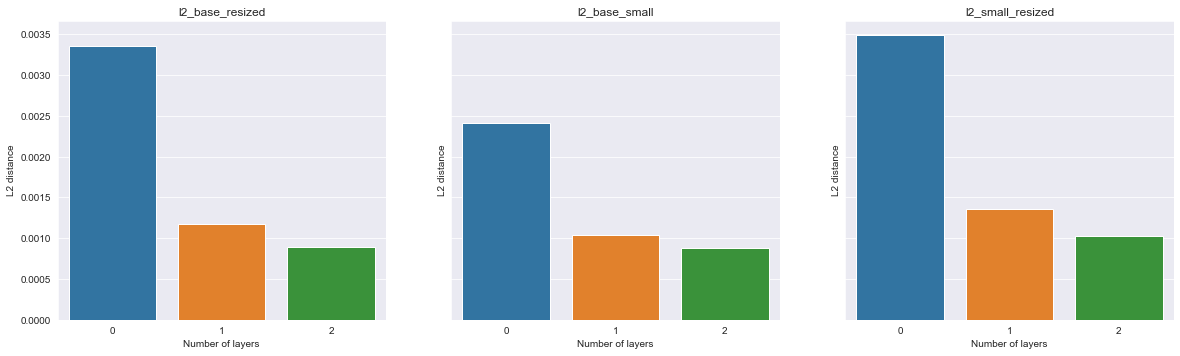

In [31]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,5.5),sharey=True,)
for ix in range(len(ax)):
    column = l2_layers.columns[ix]
    sns.barplot(x=l2_layers.index.values,y=l2_layers[column],ax=ax[ix],)
    ax[ix].set_title(column)
    ax[ix].set_xlabel('Number of layers')
    ax[ix].set_ylabel('L2 distance')

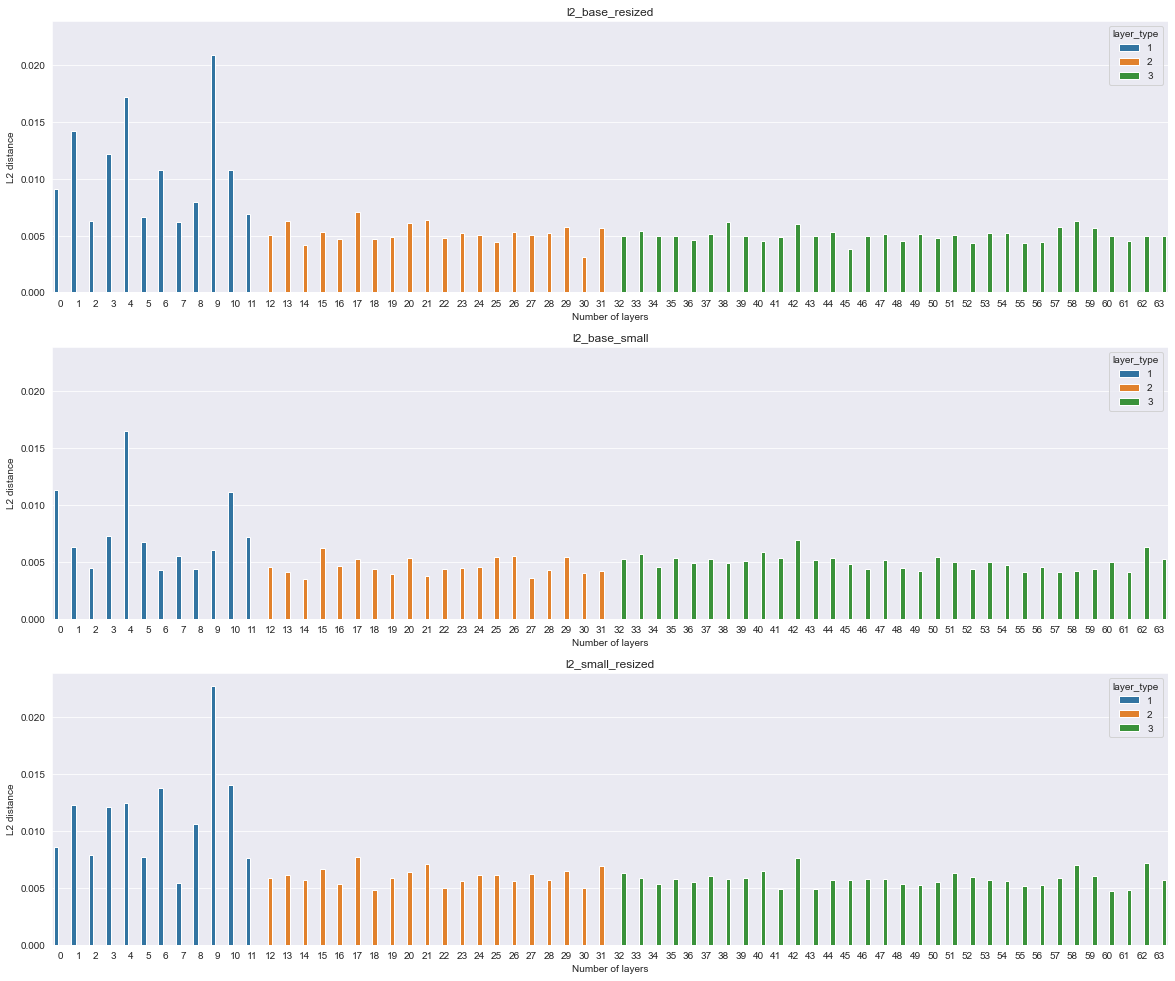

In [32]:
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(20,17),sharey=True,)
for ix in range(len(ax)):
    column = l2_layers.columns[ix]
    sns.barplot(x=l2_filters.index.values,y=l2_filters[column],ax=ax[ix],hue=l2_filters['layer_type'])
    ax[ix].set_title(column)
    ax[ix].set_xlabel('Number of layers')
    ax[ix].set_ylabel('L2 distance')

***Find 3 identical images on base, small, resized loaders - visualize first convolutions***

In [91]:
sns.set_style('whitegrid')

In [40]:
def visualize_filters_maps(image_label, weights):

    # load one batch of testing images
    plt.grid(None)
    image, label = image_label
    image = image.numpy()
    # select an image by index
    img = np.squeeze(image)
    # print(img.shape)
    img = np.moveaxis(img, 0, -1)
    plt.imshow(np.asarray(img))
    
    
    w = weights.cpu().numpy()
    fig=plt.figure(figsize=(17, 15))
    columns = 6
    rows = 4
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if ((i%2)==0):
            plt.title(f'Filter{i//2 + 1}', fontsize=14)
            plt.imshow(w[int(i/2)][0])
            plt.grid(None)

        else:
            plt.title(f'FeatureMap{i//2 + 1}', fontsize=14)
            c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
            plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
            plt.grid(None)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

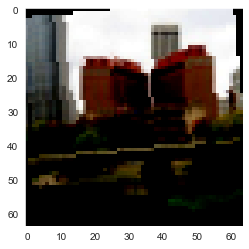

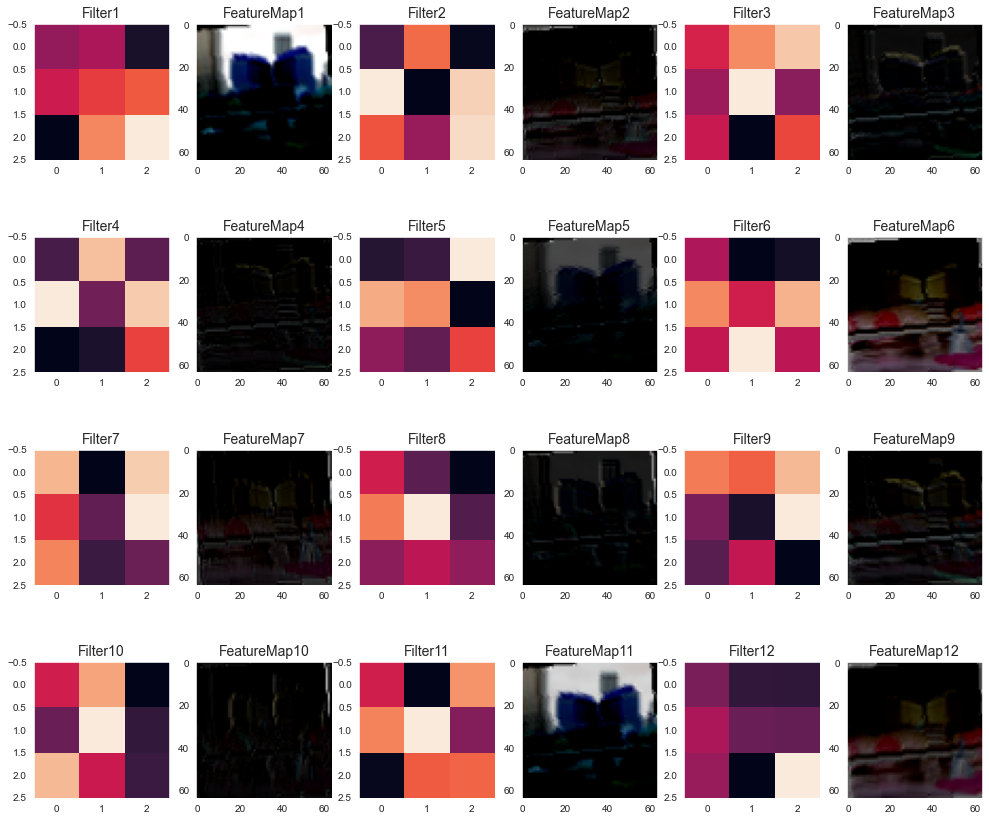

In [41]:
image_label_64_base = train_loader_64_base.dataset[8]
visualize_filters_maps(image_label_64_base, model_base.state_dict()['feature_learning.0.weight']);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

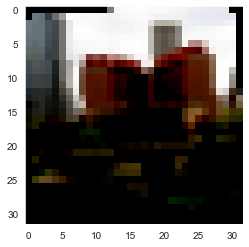

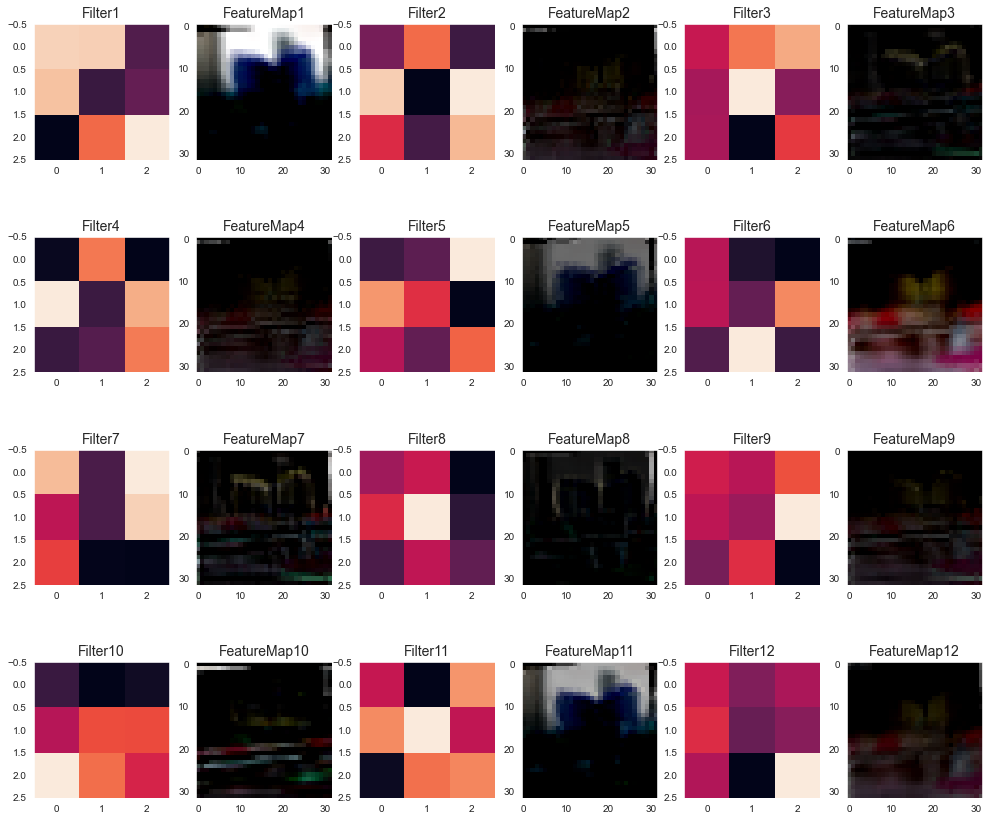

In [42]:
image_label_32 = (TF.resize(image_label_64_base[0], (32,32)), 0)
visualize_filters_maps(image_label_32, model_small.state_dict()['feature_learning.0.weight']);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

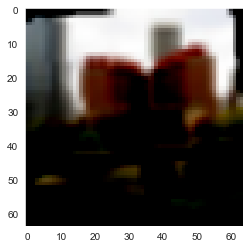

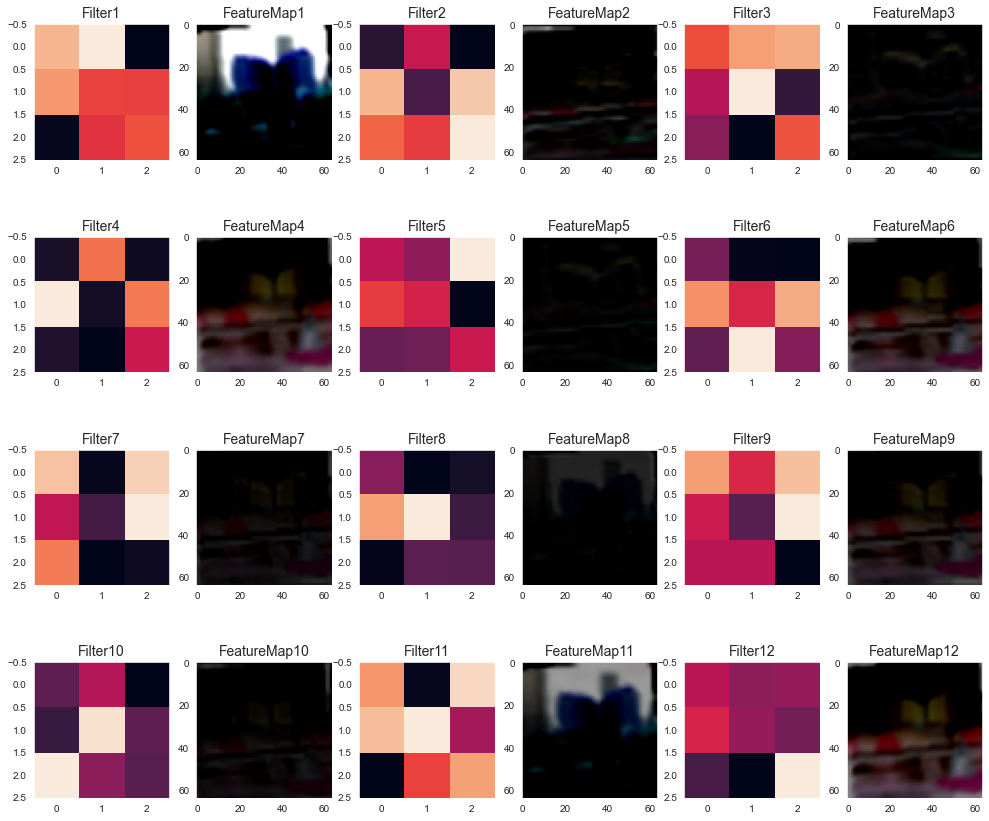

In [43]:
image_label_64_resized = (TF.resize(image_label_32[0], (64,64)), 0)
visualize_filters_maps(image_label_64_resized, model_resized.state_dict()['feature_learning.0.weight']);

## Activation maximization

In [13]:
import torch                        # tensor creation
import torchvision.models as models # get pretrained model
import act_max_util as amu          # activation maximization tools
import cv2 
import matplotlib.pyplot as plt

In [20]:
# gridsearch по різних шарах активації і input_ - картинки з датасету

In [54]:
act_max_params = {    
    'steps':100,                 # perform 500 iterations
    'alpha':torch.tensor(10),   # learning rate (step size) 
    'verbose':False,              # print activation every step
    'L2_Decay': True,            # enable L2 decay regularizer
    'Gaussian_Blur' : True,        # enable Gaussian regularizer
    'Norm_Crop' : False,            # enable norm regularizer
    'Contrib_Crop' : True 
}

In [55]:
def maximize_activations_for_classes(classes, model, dataloader, **act_max_params):

    loss = torch.nn.CrossEntropyLoss()
    fig,ax = plt.subplots(2,3, figsize=(15, 10))
    ax = ax.flatten()
    
    activation_dictionary = {}
    best_outputs_for_class = {}
    layer_name = 'classifier_final'
    model.classification[-1].register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))
    
    batch = next(iter(dataloader))
    while len(np.unique(batch[1])) != len(classes):
        batch = next(iter(dataloader))

    for unit, unit_name in enumerate(classes):
        
        # input_ = torch.randn(3, 64, 64)
        input_ = input_real_img(batch, unit)
#         input_ = input

        input_ = input_.unsqueeze(0)
        input_.requires_grad_(True)
    
        best_outputs_for_class[unit_name] = amu.act_max(network=model,
                                                        input=input_,
                                                        layer_activation=activation_dictionary,
                                                        layer_name=layer_name,
                                                        unit=unit, **act_max_params)
        final_image = amu.image_converter(best_outputs_for_class[unit_name].squeeze(0))
        ax[unit].set_title(f'{unit_name}')
        ax[unit].imshow(final_image)
        
        pred, true = model(best_outputs_for_class[unit_name])
        print(f'Loss for {unit_name} = ', loss(pred, torch.max(true, 1)[1]))
    
    return best_outputs_for_class

In [56]:
def input_real_img(batch, unit):

    pos = torch.where(batch[1] == unit)[0][0].item()
    input_ = batch[0][pos]
    return input_

Loss for buildings =  tensor(0., grad_fn=<NllLossBackward>)
Loss for forest =  tensor(0., grad_fn=<NllLossBackward>)
Loss for glacier =  tensor(0., grad_fn=<NllLossBackward>)
Loss for mountain =  tensor(0., grad_fn=<NllLossBackward>)
Loss for sea =  tensor(0., grad_fn=<NllLossBackward>)
Loss for street =  tensor(0., grad_fn=<NllLossBackward>)


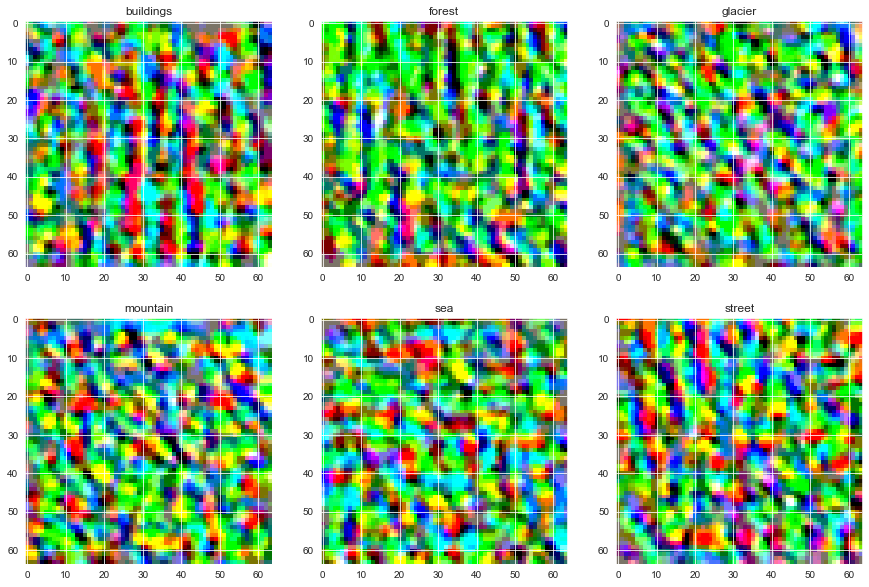

In [57]:
classes = train_loader_64_base.dataset.classes
best_outputs_64_base = maximize_activations_for_classes(classes, model_base.to('cpu'),\
                                                        train_loader_64_base, **act_max_params)

Loss for buildings =  tensor(0., grad_fn=<NllLossBackward>)
Loss for forest =  tensor(0., grad_fn=<NllLossBackward>)
Loss for glacier =  tensor(0., grad_fn=<NllLossBackward>)
Loss for mountain =  tensor(0., grad_fn=<NllLossBackward>)
Loss for sea =  tensor(0., grad_fn=<NllLossBackward>)
Loss for street =  tensor(0., grad_fn=<NllLossBackward>)


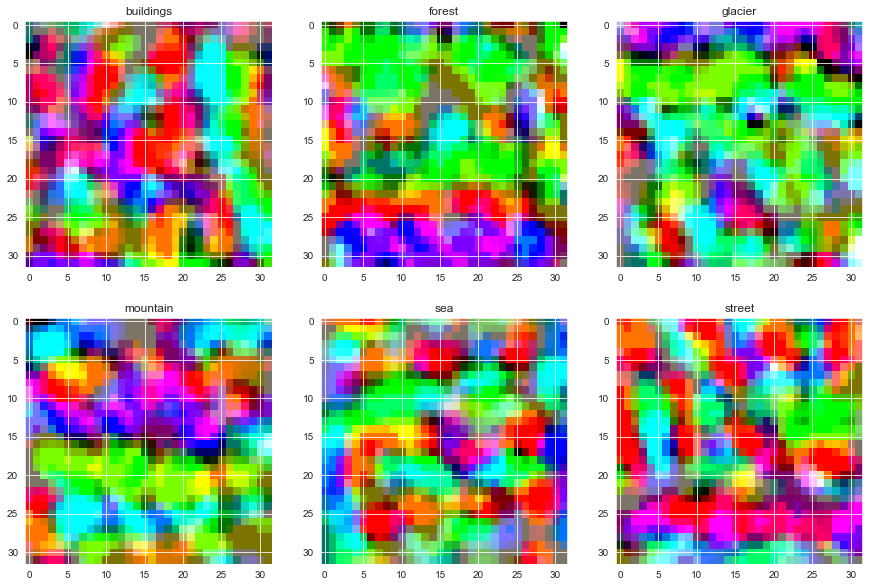

In [58]:
best_outputs_32 = maximize_activations_for_classes(classes, model_small.to('cpu'), train_loader_32, **act_max_params)

Loss for buildings =  tensor(0., grad_fn=<NllLossBackward>)
Loss for forest =  tensor(0., grad_fn=<NllLossBackward>)
Loss for glacier =  tensor(0., grad_fn=<NllLossBackward>)
Loss for mountain =  tensor(0., grad_fn=<NllLossBackward>)
Loss for sea =  tensor(0., grad_fn=<NllLossBackward>)
Loss for street =  tensor(0., grad_fn=<NllLossBackward>)


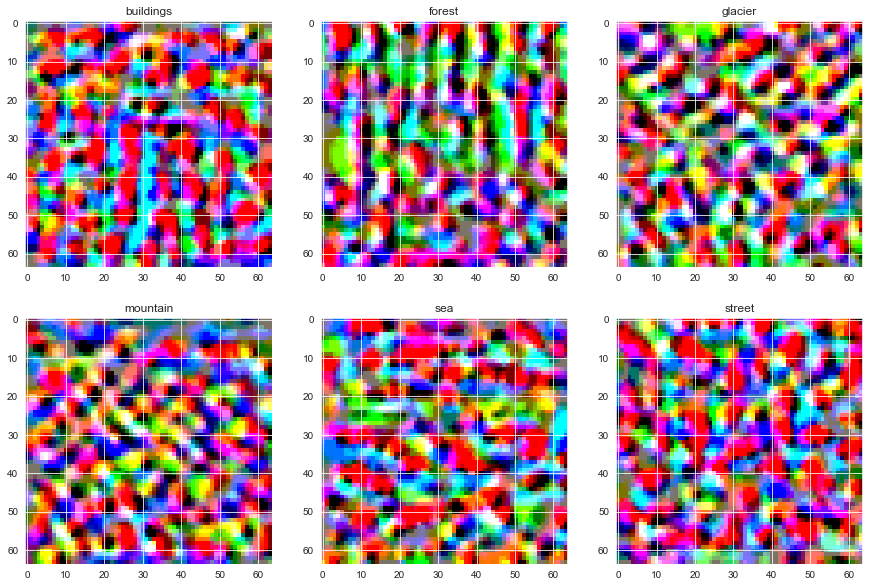

In [59]:
best_outputs_64_resized = maximize_activations_for_classes(classes, model_resized.to('cpu'),\
                                                           train_loader_64_resized, **act_max_params)